# Lending Club Loan pre-issue credit risk model

## Update log

* __20170328__: Initial script
* __20170608__: Updated the code under pandas 0.20.2 version
* __20170610__: Rebuilt core model

## Scope of modeling

This script is used to build the pre-issue credit risk model.

1. We focus on __closed deals__ only and try to classify between __default__ loans and __non-default__ loans. Current ongoing loans and fresh issued loan is not included in the scope of modeling.
2. Since this is a __pre-issue credit risk model__ instead of a model for __real-time default detection__, only __variables collected prior to the issue day of the loan__ will be included as predictor variables (like loan information, current credit history). We do not include variables that are collected real-time throughout the loan period (like last payment day).

In [2]:
import random
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, make_scorer, confusion_matrix, f1_score

## Load Data from csv

In [4]:
# read csv (441.8 MB)
loan = pd.read_csv("../data/loan.csv", low_memory=False)
loan_copy = loan.copy()
# check dimension
print loan.shape

(887379, 74)


In [75]:
# reset loan variable
loan = loan_copy.copy()

## Set up response variable

In [6]:
# all categories of loan_status
loan['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

Loans with status "Current" represent loans that haven't been closed till Jan-2016 (the latest payment month in our data). For this analysis, we focus on closed deals only and try to classify between default and non-default.

The loan_status of closed deals are:

* __Fully Paid__ (non-default)
* __Charged Off__ (default)
* __Default__ (defualt)

In [76]:
# filter response categories
loan = loan[loan['loan_status'].isin(['Fully Paid','Charged Off','Default'])]
# set up binary response variable
default = loan['loan_status'].map({"Fully Paid": 0.0,"Charged Off": 1.0,"Default": 1.0})
loan['default'] = default
# delete loan_status from data frame
# loan.drop('loan_status', axis=1, inplace=True)

In [77]:
# check dimension
print loan.shape
print default.shape

(254190, 75)
(254190,)


## Predictor variables exploration

In [5]:
# check column names
loan.columns.sort_values()

Index([u'acc_now_delinq', u'addr_state', u'all_util', u'annual_inc',
       u'annual_inc_joint', u'application_type', u'collection_recovery_fee',
       u'collections_12_mths_ex_med', u'delinq_2yrs', u'desc', u'dti',
       u'dti_joint', u'earliest_cr_line', u'emp_length', u'emp_title',
       u'funded_amnt', u'funded_amnt_inv', u'grade', u'home_ownership', u'id',
       u'il_util', u'initial_list_status', u'inq_fi', u'inq_last_12m',
       u'inq_last_6mths', u'installment', u'int_rate', u'issue_d',
       u'last_credit_pull_d', u'last_pymnt_amnt', u'last_pymnt_d',
       u'loan_amnt', u'loan_status', u'max_bal_bc', u'member_id',
       u'mths_since_last_delinq', u'mths_since_last_major_derog',
       u'mths_since_last_record', u'mths_since_rcnt_il', u'next_pymnt_d',
       u'open_acc', u'open_acc_6m', u'open_il_12m', u'open_il_24m',
       u'open_il_6m', u'open_rv_12m', u'open_rv_24m', u'out_prncp',
       u'out_prncp_inv', u'policy_code', u'pub_rec', u'purpose', u'pymnt_plan',
      

### 1. Keep pre-issue variables only

Pre-issue variables are variables representing basic loan information, borrower's demographic, income, credit history and other information collected when applying for loan. They are:

* addr_state
* annual_inc
* annual_inc_joint
* application_type
* desc
* earliest_cr_line
* emp_length
* emp_title
* grade
* home_ownership
* id
* initialListStatus
* installment
* int_rate
* issue_d
* loan_amnt
* member_id
* policy_code
* purpose
* pymnt_plan
* sub_grade
* term
* title
* url
* verified_status_joint
* zip_code

In [80]:
# keep pre-issue variables
loan = loan[['addr_state','annual_inc','annual_inc_joint','application_type','desc','earliest_cr_line',
             'emp_length','emp_title','grade','home_ownership','id','initial_list_status','installment',
             'int_rate','issue_d','loan_amnt','member_id','policy_code','purpose','pymnt_plan',
             'sub_grade','term','title','url','verification_status','zip_code']]
loan.shape

### 2. Drop irrelevant variables.

In [103]:
loan['title'].str.contains('consolidation|Consolidation').mean()

0.4310286492143301

In [105]:
loan['emp_title'].str.contains('Bank').mean()

0.012902661720438167

In [42]:
# drop irrelavent variables
loan.drop(['id','member_id', 'desc', 'url', 'zip_code'], axis=1, inplace=True)
# check dimension
loan.shape

(254190, 68)

### 2. Check missing values

In [11]:
# NA count table
NAs = pd.concat([loan.isnull().sum(), np.round(loan.isnull().sum()/len(loan), 2)], axis=1, keys=['missing counts','missing percentage'])

In [19]:
# print all variables that have NAs
NAs[NAs['missing percentage'] != 0.0].sort_values('missing percentage')

,missing counts,missing percentage
total_rev_hi_lim,63726,0.25
tot_coll_amt,63726,0.25
tot_cur_bal,63726,0.25
mths_since_last_delinq,141446,0.56
mths_since_last_major_derog,206314,0.81
mths_since_last_record,222376,0.87
inq_fi,254046,1.00
all_util,254046,1.00
max_bal_bc,254046,1.00
open_rv_24m,254046,1.00


We drop variables that have over 90% NAs. Those variables cannot be used since 

In [163]:
# drop NA variables
loan.drop(list(NAs[NAs['missing percentage'] > 0.5].index), axis=1, inplace=True)
# check dimension
loan.shape

(254190, 49)

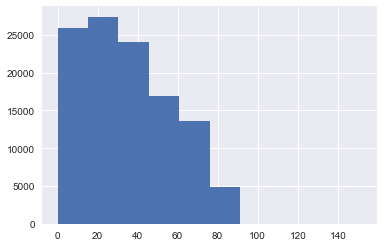

In [18]:
loan['mths_since_last_delinq'].hist()

## Data Cleaning & Feature engineering

1. generate new variable using existing variables
2. drop redundant variables
3. change variable to proper data type

__loan_amnt, funded_amnt, funded_amnt_inv__

In [84]:
# loan_amnt is always greater than funded_amnt and funded_amnt_inv
print (loan['loan_amnt'] >= loan['funded_amnt']).mean()
print (loan['loan_amnt'] >= loan['funded_amnt_inv']).mean()

# add variable perc_funded_inv: The amount committed by investors divided by total loan amount.
loan['perc_funded_amnt'] = loan['funded_amnt'] / loan['loan_amnt']
loan['perc_funded_amnt_inv'] = loan['funded_amnt_inv'] / loan['loan_amnt']

# delete funded_amnt, funded_amnt_inv
loan.drop('funded_amnt', axis=1, inplace=True)
loan.drop('funded_amnt_inv', axis=1, inplace=True)

1.0
1.0


__grade, sub_grade__

In [85]:
print loan['grade'].unique()
print loan['sub_grade'].unique()
print len(loan['sub_grade'].unique())

# map the grades to a continuous variable
loan['grade_level'] = loan['sub_grade'].map({'A1':1,'A2':2,'A3':3,'A4':4,'A5':5,
                      'B1':6,'B2':7,'B3':8,'B4':9,'B5':10,
                      'C1':11,'C2':12,'C3':13,'C4':14,'C5':15,
                      'D1':16,'D2':17,'D3':18,'D4':19,'D5':20,
                      'E1':21,'E2':22,'E3':23,'E4':24,'E5':25,
                      'F1':26,'F2':27,'F3':28,'F4':29,'F5':30,
                      'G1':31,'G2':32,'G3':33,'G4':34,'G5':35,})

# delete grade, sub_grade
loan.drop(['grade', 'sub_grade'], axis=1, inplace=True)

['B' 'C' 'A' 'E' 'F' 'D' 'G']
['B2' 'C4' 'C5' 'C1' 'A4' 'E1' 'F2' 'B5' 'C3' 'B1' 'D1' 'A1' 'B3' 'B4' 'C2'
 'D2' 'A3' 'A5' 'D5' 'A2' 'E4' 'D3' 'D4' 'F3' 'E3' 'F1' 'E5' 'G4' 'E2' 'G2'
 'G1' 'F5' 'F4' 'G5' 'G3']
35


__emp_length__: Variable emp_length has 11 categories, we cut the them into 4 different ranges.

In [86]:
# before cut
print loan['emp_length'].value_counts()

# cut
loan['emp_length'] = loan['emp_length'].map({'10+ years': '10+ years',
                       '9 years': '6-9 years',
                       '8 years': '6-9 years',
                       '7 years': '6-9 years',
                       '6 years': '6-9 years',
                       '5 years': '3-5 years',
                       '4 years': '3-5 years',
                       '3 years': '3-5 years',
                       '2 years': '0-2 years',
                       '1 year': '0-2 years',
                       '< 1 year': '0-2 years',
                       'n/a': '0-2 years' # no employment information
                      })

# after cut
print loan['emp_length'].value_counts()

10+ years    77256
2 years      23647
< 1 year     20975
3 years      20484
5 years      18136
1 year       16951
4 years      16263
6 years      14816
7 years      14156
8 years      11922
n/a           9968
9 years       9616
Name: emp_length, dtype: int64
10+ years    77256
0-2 years    71541
3-5 years    54883
6-9 years    50510
Name: emp_length, dtype: int64


__pymnt_plan, policy_code, application_type__: Alomost constant. Drop them.

In [87]:
# drop almost-constant variables
print loan['pymnt_plan'].value_counts()
print loan['policy_code'].value_counts()
print loan['application_type'].value_counts()

# delete them
loan.drop(['pymnt_plan', 'policy_code', 'application_type'], axis=1, inplace=True)

n    254188
y         2
Name: pymnt_plan, dtype: int64
1.0    254190
Name: policy_code, dtype: int64
INDIVIDUAL    254189
JOINT              1
Name: application_type, dtype: int64


__issue_d, earliest_cr_line__: take the difference to get the number of days since earliest credit line.

In [88]:
# convert to date
loan['issue_d'] = pd.to_datetime(loan['issue_d'])
loan['earliest_cr_line'] = pd.to_datetime(loan['earliest_cr_line'])

# take the difference
loan['days_since_earliest_cr_line'] = loan['issue_d'] - loan['earliest_cr_line']

# drop issue_d and earliest_cr_line
loan.drop(['issue_d', 'earliest_cr_line'], axis=1, inplace=True)

In [89]:
loan.columns

Index([u'loan_amnt', u'term', u'int_rate', u'installment', u'emp_length',
       u'home_ownership', u'annual_inc', u'verification_status', u'purpose',
       u'addr_state', u'dti', u'delinq_2yrs', u'inq_last_6mths', u'open_acc',
       u'pub_rec', u'revol_bal', u'revol_util', u'total_acc',
       u'initial_list_status', u'out_prncp', u'out_prncp_inv', u'total_pymnt',
       u'total_pymnt_inv', u'total_rec_prncp', u'total_rec_int',
       u'total_rec_late_fee', u'recoveries', u'collection_recovery_fee',
       u'last_pymnt_d', u'last_pymnt_amnt', u'last_credit_pull_d',
       u'collections_12_mths_ex_med', u'acc_now_delinq', u'perc_funded_amnt',
       u'perc_funded_amnt_inv', u'grade_level',
       u'days_since_earliest_cr_line'],
      dtype='object')

__last_pymnt_d, last_credit_pull_d__: take the difference.

In [144]:
# convert to date
loan['last_pymnt_d'] = pd.to_datetime(loan['last_pymnt_d'])
loan['last_credit_pull_d'] = pd.to_datetime(loan['last_credit_pull_d'])

# take the difference
loan['days_diff_last_pymnt_pull'] = loan['last_credit_pull_d'] - loan['last_pymnt_d']

# drop issue_d and earliest_cr_line
loan.drop(['last_pymnt_d', 'last_credit_pull_d'], axis=1, inplace=True)

Now check data types.

In [154]:
# NA count table
print loan.shape
NAs = pd.concat([loan.dtypes, loan.isnull().sum(), np.round(loan.isnull().sum()/len(loan), 2)], axis=1, keys=['Type', 'missing counts','missing percentage'])
NAs

(254190, 35)


,Type,missing counts,missing percentage
loan_amnt,float64,0,0.0
term,object,0,0.0
int_rate,float64,0,0.0
installment,float64,0,0.0
emp_length,object,0,0.0
home_ownership,object,0,0.0
annual_inc,float64,0,0.0
verification_status,object,0,0.0
purpose,object,0,0.0
addr_state,object,0,0.0


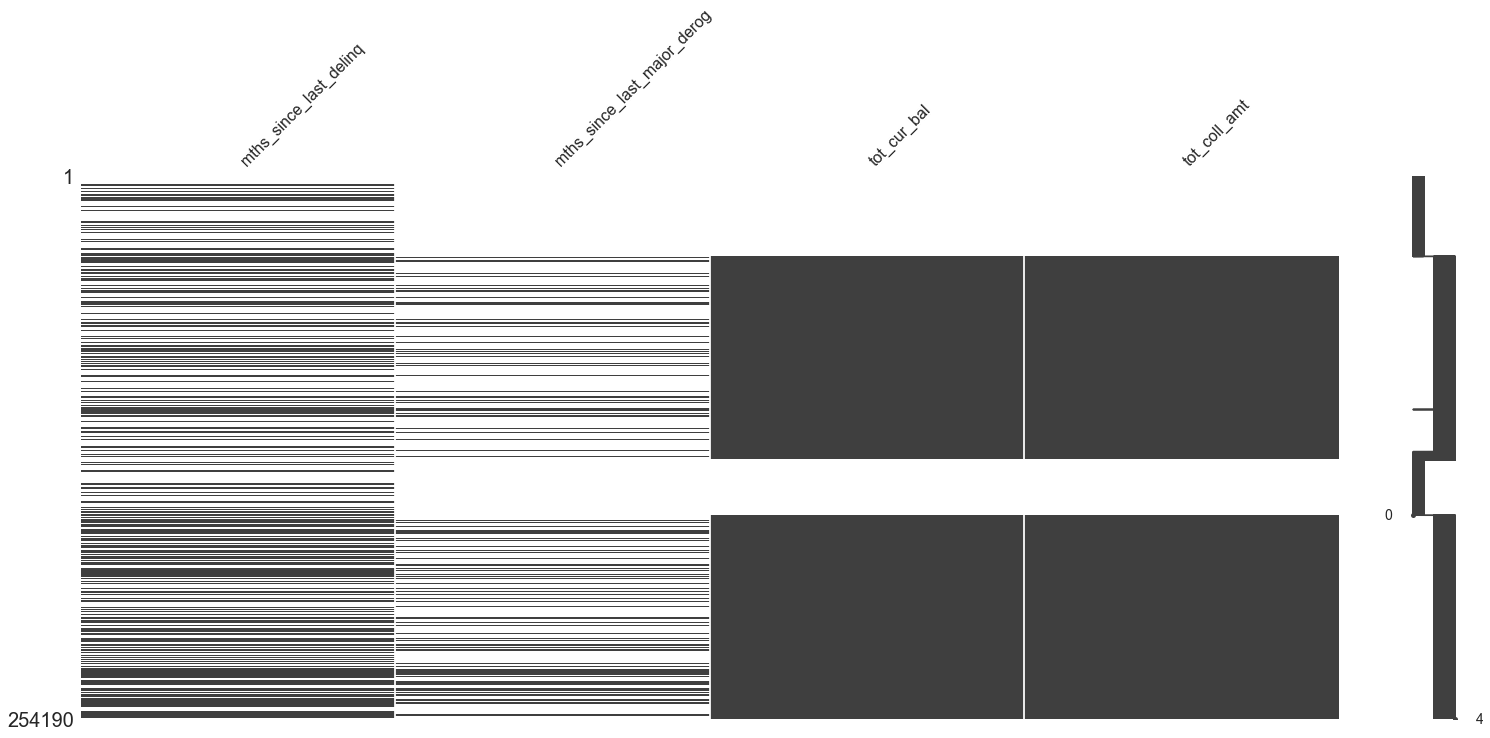

In [197]:
mn.matrix(loan[['mths_since_last_delinq','mths_since_last_major_derog','','tot_cur_bal','tot_coll_amt']])

## Performance Metric

We use AUC (Area-under-the-curve) as an optimization metric. This is a popular metric within credit modeling.

In [3]:
def get_auc(y_true, y_pred):
    # y: an array of labels marking the actualy result as default (1) or non-default (0) 
    # y_pred: a probability that a row has defaulted
    # fpr: false-positive rate
    # tpr: true-positive rate
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)
    return auc_score